#### This demo might not work with T4 colab (please use GPU with higher VRAM). How? `Runtime` -> `Change run time type`

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rohitgandikota/sliders/blob/main/demo_image_editing.ipynb)

In [1]:
!cd sliders
!pip install -r sliders/requirements.txt
!pip install accelerate
import os 
!wget https://sliders.baulab.info/sample_images/stock_photo_girl.jpg

cd: The directory 'sliders' does not exist
/usr/share/fish/functions/cd.fish (line 30): 
    builtin cd $argv
    ^
in function 'cd' with arguments 'sliders'
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'sliders/requirements.txt'
--2024-04-15 06:05:06--  https://sliders.baulab.info/sample_images/stock_photo_girl.jpg
Resolving sliders.baulab.info (sliders.baulab.info)... 35.232.255.106
Connecting to sliders.baulab.info (sliders.baulab.info)|35.232.255.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 729418 (712K) [image/jpeg]
Saving to: ‘stock_photo_girl.jpg’

stock_photo_girl.jp 100%[===================>] 712.32K   795KB/s    in 0.9s    

2024-04-15 06:05:12 (795 KB/s) - ‘stock_photo_girl.jpg’ saved [729418/729418]



In [2]:
import torch
from PIL import Image
import argparse
import os, json, random
import pandas as pd
import matplotlib.pyplot as plt
import glob, re
import random


from safetensors.torch import load_file
import matplotlib.image as mpimg
import copy
import gc
from transformers import CLIPTextModel, CLIPTokenizer

import diffusers
from diffusers import DiffusionPipeline
from diffusers import AutoencoderKL, DDPMScheduler, DiffusionPipeline, UNet2DConditionModel, LMSDiscreteScheduler
from diffusers.loaders import AttnProcsLayers
from diffusers.models.attention_processor import LoRAAttnProcessor, AttentionProcessor


from typing import Optional, Union, Tuple, List, Callable, Dict
from tqdm.notebook import tqdm
from diffusers import StableDiffusionPipeline, DDIMScheduler
import torch.nn.functional as nnf
import numpy as np
import abc
import shutil
from torch.optim.adam import Adam

try:
    os.chdir('sliders')
except:
    pass

import trainscripts.textsliders.ptp_utils as ptp_utils
from trainscripts.textsliders.lora import LoRANetwork, DEFAULT_TARGET_REPLACE, UNET_TARGET_REPLACE_MODULE_CONV

In [3]:
scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
LOW_RESOURCE = False 
NUM_DDIM_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
weight_dtype = torch.float32 # if you are using GPU >T4 in colab you can use bfloat16
device = 'cuda'
device = torch.device(device)
ldm_stable = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", scheduler=scheduler, torch_dtype=weight_dtype).to(device)
try:
    ldm_stable.disable_xformers_memory_efficient_attention()
except AttributeError:
    print("Attribute disable_xformers_memory_efficient_attention() is missing")
tokenizer = ldm_stable.tokenizer

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/twei/anaconda3/envs/yolanda/lib/python3.10/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:128: FutureWarning: The configuration file of this scheduler: DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.20.2",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "set_alpha_to_one": false,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null
}
 is outdated. `steps_offset` should be set to 1 instead of 0. Please make sure to update the config accordingly as leaving `steps_offset` might led to incorrect results in future versions. If you have downloaded this checkpoint from the Hugging Face Hub, it would be very nice if you could ope

# Null Inversion to the capture image 

In [4]:
def load_512(image_path, left=0, right=0, top=0, bottom=0):
    if type(image_path) is str:
        image = np.array(Image.open(image_path))[:, :, :3]
    else:
        image = image_path
    h, w, c = image.shape
    left = min(left, w-1)
    right = min(right, w - left - 1)
    top = min(top, h - left - 1)
    bottom = min(bottom, h - top - 1)
    image = image[top:h-bottom, left:w-right]
    h, w, c = image.shape
    if h < w:
        offset = (w - h) // 2
        image = image[:, offset:offset + h]
    elif w < h:
        offset = (h - w) // 2
        image = image[offset:offset + w]
    image = np.array(Image.fromarray(image).resize((512, 512)))
    return image


class NullInversion:
    
    def prev_step(self, model_output: Union[torch.FloatTensor, np.ndarray], timestep: int, sample: Union[torch.FloatTensor, np.ndarray]):
        prev_timestep = timestep - self.scheduler.config.num_train_timesteps // self.scheduler.num_inference_steps
        alpha_prod_t = self.scheduler.alphas_cumprod[timestep]
        alpha_prod_t_prev = self.scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else self.scheduler.final_alpha_cumprod
        beta_prod_t = 1 - alpha_prod_t
        pred_original_sample = (sample - beta_prod_t ** 0.5 * model_output) / alpha_prod_t ** 0.5
        pred_sample_direction = (1 - alpha_prod_t_prev) ** 0.5 * model_output
        prev_sample = alpha_prod_t_prev ** 0.5 * pred_original_sample + pred_sample_direction
        return prev_sample
    
    def next_step(self, model_output: Union[torch.FloatTensor, np.ndarray], timestep: int, sample: Union[torch.FloatTensor, np.ndarray]):
        timestep, next_timestep = min(timestep - self.scheduler.config.num_train_timesteps // self.scheduler.num_inference_steps, 999), timestep
        alpha_prod_t = self.scheduler.alphas_cumprod[timestep] if timestep >= 0 else self.scheduler.final_alpha_cumprod
        alpha_prod_t_next = self.scheduler.alphas_cumprod[next_timestep]
        beta_prod_t = 1 - alpha_prod_t
        next_original_sample = (sample - beta_prod_t ** 0.5 * model_output) / alpha_prod_t ** 0.5
        next_sample_direction = (1 - alpha_prod_t_next) ** 0.5 * model_output
        next_sample = alpha_prod_t_next ** 0.5 * next_original_sample + next_sample_direction
        return next_sample
    
    def get_noise_pred_single(self, latents, t, context):
        noise_pred = self.model.unet(latents, t, encoder_hidden_states=context)["sample"]
        return noise_pred

    def get_noise_pred(self, latents, t, is_forward=True, context=None):
        latents_input = torch.cat([latents] * 2)
        latents_input = latents_input.to(self.model.unet.dtype)
        if context is None:
            context = self.context
        guidance_scale = 1 if is_forward else GUIDANCE_SCALE
        noise_pred = self.model.unet(latents_input, t, encoder_hidden_states=context)["sample"]
        noise_pred_uncond, noise_prediction_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_prediction_text - noise_pred_uncond)
        if is_forward:
            latents = self.next_step(noise_pred, t, latents)
        else:
            latents = self.prev_step(noise_pred, t, latents)
        return latents

    @torch.no_grad()
    def latent2image(self, latents, return_type='np'):
        latents = 1 / 0.18215 * latents.detach()
        latents = latents.to(self.model.vae.dtype)
        image = self.model.vae.decode(latents)['sample']
        if return_type == 'np':
            image = (image / 2 + 0.5).clamp(0, 1)
            image = image.cpu().permute(0, 2, 3, 1).to(torch.float16).numpy()[0]
            image = (image * 255).astype(np.uint8)
        return image

    @torch.no_grad()
    def image2latent(self, image):
        with torch.no_grad():
            if type(image) is Image:
                image = np.array(image)
            if type(image) is torch.Tensor and image.dim() == 4:
                latents = image
            else:
                image = torch.from_numpy(image).float() / 127.5 - 1
                image = image.permute(2, 0, 1).unsqueeze(0).to(device).to(self.model.vae.dtype)
                latents = self.model.vae.encode(image)['latent_dist'].mean
                latents = latents * 0.18215
        return latents

    @torch.no_grad()
    def init_prompt(self, prompt: str):
        uncond_input = self.model.tokenizer(
            [""], padding="max_length", max_length=self.model.tokenizer.model_max_length,
            return_tensors="pt"
        )
        uncond_embeddings = self.model.text_encoder(uncond_input.input_ids.to(self.model.device))[0]
        text_input = self.model.tokenizer(
            [prompt],
            padding="max_length",
            max_length=self.model.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_embeddings = self.model.text_encoder(text_input.input_ids.to(self.model.device))[0]
        self.context = torch.cat([uncond_embeddings, text_embeddings])
        self.prompt = prompt

    @torch.no_grad()
    def ddim_loop(self, latent):
        uncond_embeddings, cond_embeddings = self.context.chunk(2)
        all_latent = [latent]
        latent = latent.clone().detach()
        latent = latent.to(self.model.unet.dtype)
        for i in range(NUM_DDIM_STEPS):
            t = self.model.scheduler.timesteps[len(self.model.scheduler.timesteps) - i - 1]
            noise_pred = self.get_noise_pred_single(latent, t, cond_embeddings)
            latent = self.next_step(noise_pred, t, latent)
            all_latent.append(latent)
        return all_latent

    @property
    def scheduler(self):
        return self.model.scheduler

    @torch.no_grad()
    def ddim_inversion(self, image):
        latent = self.image2latent(image)
        image_rec = self.latent2image(latent)
        ddim_latents = self.ddim_loop(latent)
        
        return image_rec, ddim_latents

    def null_optimization(self, latents, num_inner_steps, epsilon):
        uncond_embeddings, cond_embeddings = self.context.chunk(2)
        uncond_embeddings_list = []
        latent_cur = latents[-1]
        bar = tqdm(total=num_inner_steps * NUM_DDIM_STEPS)
        for i in range(NUM_DDIM_STEPS):
            uncond_embeddings = uncond_embeddings.clone().detach()
            uncond_embeddings.requires_grad = True
            optimizer = Adam([uncond_embeddings], lr=1e-2 * (1. - i / 100.))
            latent_prev = latents[len(latents) - i - 2]
            t = self.model.scheduler.timesteps[i]
            with torch.no_grad():
                noise_pred_cond = self.get_noise_pred_single(latent_cur, t, cond_embeddings)
            for j in range(num_inner_steps):
                noise_pred_uncond = self.get_noise_pred_single(latent_cur, t, uncond_embeddings)
                noise_pred = noise_pred_uncond + GUIDANCE_SCALE * (noise_pred_cond - noise_pred_uncond)
                latents_prev_rec = self.prev_step(noise_pred, t, latent_cur)
                loss = nnf.mse_loss(latents_prev_rec, latent_prev)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                loss_item = loss.item()
                bar.update()
                if loss_item < epsilon + i * 2e-5:
                    break
            for j in range(j + 1, num_inner_steps):
                bar.update()
            uncond_embeddings_list.append(uncond_embeddings[:1].detach())
            with torch.no_grad():
                context = torch.cat([uncond_embeddings, cond_embeddings])
                latent_cur = self.get_noise_pred(latent_cur, t, False, context)
        bar.close()
        return uncond_embeddings_list
    
    def invert(self, image_path: str, prompt: str, offsets=(0,0,0,0), num_inner_steps=10, early_stop_epsilon=1e-5, verbose=False):
        self.init_prompt(prompt)
        ptp_utils.register_attention_control(self.model, None)
        
        image_gt = load_512(image_path, *offsets)
        display(Image.fromarray(image_gt))
        
        if verbose:
            print("DDIM inversion...")
        image_rec, ddim_latents = self.ddim_inversion(image_gt)
        if verbose:
            print("Null-text optimization...")
        uncond_embeddings = self.null_optimization(ddim_latents, num_inner_steps, early_stop_epsilon)
        return (image_gt, image_rec), ddim_latents[-1], uncond_embeddings
        
    
    def __init__(self, model):
        scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False,
                                  set_alpha_to_one=False)
        self.model = model
        self.tokenizer = self.model.tokenizer
        self.model.scheduler.set_timesteps(NUM_DDIM_STEPS)
        self.prompt = None
        self.context = None

null_inversion = NullInversion(ldm_stable)

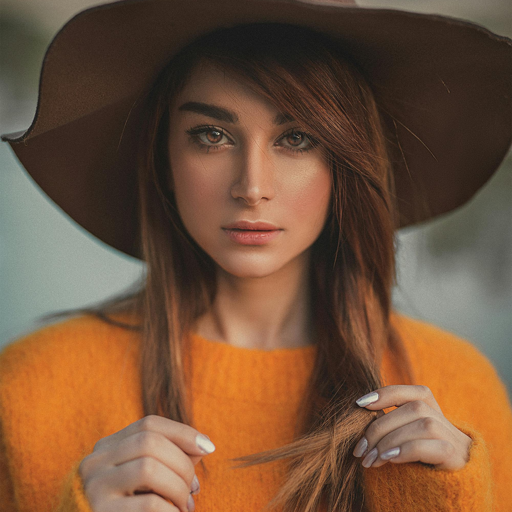

DDIM inversion...
Null-text optimization...


  0%|          | 0/500 [00:00<?, ?it/s]

In [5]:
image_path = "stock_photo_girl.jpg"
prompt = "photo of a person"
(image_gt, image_enc), x_t, uncond_embeddings = null_inversion.invert(image_path, prompt, offsets=(0,0,0,0), verbose=True)

print("Modify or remove offsets according to your image!")

In [ ]:
Image.fromarray(image_enc)

In [ ]:
import copy
uncond_embeddings_copy = copy.deepcopy(uncond_embeddings)

In [ ]:
def flush():
    torch.cuda.empty_cache()
    gc.collect()
flush()
width = 512
height = 512 
steps = 50  
cfg_scale = 7.5 

del ldm_stable
flush()

In [ ]:
pretrained_model_name_or_path = "CompVis/stable-diffusion-v1-4"

revision = None
device = 'cuda'
rank = 4


# Load scheduler, tokenizer and models.
noise_scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path, subfolder="tokenizer", revision=revision
)
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder", revision=revision
)
vae = AutoencoderKL.from_pretrained(pretrained_model_name_or_path, subfolder="vae", revision=revision)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="unet", revision=revision
)
# freeze parameters of models to save more memory
unet.requires_grad_(False)
unet.to(device, dtype=weight_dtype)
vae.requires_grad_(False)

text_encoder.requires_grad_(False)

# For mixed precision training we cast all non-trainable weigths (vae, non-lora text_encoder and non-lora unet) to half-precision
# as these weights are only used for inference, keeping weights in full precision is not required.


# Move unet, vae and text_encoder to device and cast to weight_dtype
vae.requires_grad_(False)
vae.to(device, dtype=weight_dtype)
text_encoder.to(device, dtype=weight_dtype)

In [ ]:
slider1 = './models/age.pt'

train_method = 'noxattn'
network_type = "c3lier"
if train_method == 'xattn':
    network_type = 'lierla'

modules = DEFAULT_TARGET_REPLACE
if network_type == "c3lier":
    modules += UNET_TARGET_REPLACE_MODULE_CONV
import os
model_name = slider1

name = os.path.basename(model_name)
alpha = 1.0
# freeze parameters of models to save more memory
unet.requires_grad_(False)
unet.to(device, dtype=weight_dtype)
network1 = LoRANetwork(
        unet,
        rank=4,
        multiplier=1.0,
        alpha=alpha,
        train_method=train_method,
    ).to(device, dtype=weight_dtype)
network1.load_state_dict(torch.load(slider1))

torch_device = device
negative_prompt = None
batch_size = 1
height = 512
width = 512
ddim_steps = 50
guidance_scale = 7.5

In [ ]:
scales1 = [0, 2, 4]
start_noise = 500 # use smaller values for real image editing so that the identity does not change

images_list = []
for scale1 in scales1:
    
   
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

    text_embeddings_ = text_encoder(text_input.input_ids.to(torch_device))[0]

    max_length = text_input.input_ids.shape[-1]

    noise_scheduler.set_timesteps(ddim_steps)


    latents = x_t* noise_scheduler.init_noise_sigma
    latents = latents.to(unet.dtype)
    cnt = -1
    for t in tqdm(noise_scheduler.timesteps):
        cnt+=1
        if t>start_noise:
            network1.set_lora_slider(scale=0)
        else:
            network1.set_lora_slider(scale=scale1)
        
        text_embeddings = torch.cat([uncond_embeddings_copy[cnt].expand(*text_embeddings_.shape), text_embeddings_])
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        text_embeddings = text_embeddings.to(weight_dtype)
        latent_model_input = noise_scheduler.scale_model_input(latent_model_input, timestep=t)
        # predict the noise residual
        
        with torch.no_grad():
            with network1:
                noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = noise_scheduler.step(noise_pred, t, latents).prev_sample

    # scale and decode the image latents with vae
    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).to(torch.float16).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    images_list.append(pil_images[0])

fig, ax = plt.subplots(1, len(images_list), figsize=(20,4))
for i, a in enumerate(ax):
    a.imshow(images_list[i])
    a.axis('off')


plt.show()

for im in images_list:
    display(im)